# Data and ML performance Analysis
### Aoife Sullivan

Contents: 
1. Import Libraries and data
2. Overview of missing values/data quality
3. New Columns
4. Initial points of Interest: Market/Customer
5. Initial points of interest: Amount Refunded
6. Initial points of interest: Risk Score + Decisions
7. ML Performance
8. Extra & Unfinished


## Import libraries and data

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt

In [2]:
df = pd.read_excel('Test dataset.xlsx')

In [3]:
df.shape

(141, 10)

In [4]:
#having a quick overview of the data to make sure everything looks the same as the sheet
df.head(10)

,Customer case,Contact category,Market,Customer category,Risk score,Article type,Refunded amount,Flagged for manual review,Decision by Customer Care,Reassessment by Fraud Analyst
0,1,Return,Germany,A (Premium),0.97820,Sneakers,75.95,1,FRAUD,FRAUD
1,2,Return,Germany,A (Premium),0.32877,Jeans,227.05,1,NOT FRAUD,NOT FRAUD
2,3,Return,Germany,C,0.97888,Sneakers,199.95,1,FRAUD,FRAUD
3,4,Delivery,France,B,0.97890,Sneakers,119.95,1,NOT FRAUD,NOT FRAUD
4,5,Delivery,Germany,C,0.97892,Jeans,33.95,1,FRAUD,FRAUD
5,6,Return,Germany,B,0.97927,Sweatshirt,27.95,1,NOT FRAUD,NOT FRAUD
6,7,Return,Germany,B,0.97927,Trousers,37.45,1,NOT FRAUD,NOT FRAUD
7,8,Delivery,Germany,A (Premium),0.97960,Pumps,249.95,1,NOT FRAUD,NOT FRAUD
8,9,Delivery,Germany,C,0.57970,Underwear,19.99,1,NOT FRAUD,FRAUD
9,10,Return,Germany,A (Premium),0.97973,Dress,44.99,1,FRAUD,FRAUD


# Quick overview of data qualities and any nulls

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer case                  141 non-null    int64  
 1   Contact category               141 non-null    object 
 2   Market                         141 non-null    object 
 3   Customer category              141 non-null    object 
 4   Risk score                     141 non-null    float64
 5   Article type                   141 non-null    object 
 6   Refunded amount                141 non-null    float64
 7   Flagged for manual review      141 non-null    int64  
 8   Decision by Customer Care      108 non-null    object 
 9   Reassessment by Fraud Analyst  141 non-null    object 
dtypes: float64(2), int64(2), object(6)
memory usage: 11.1+ KB


<AxesSubplot:>

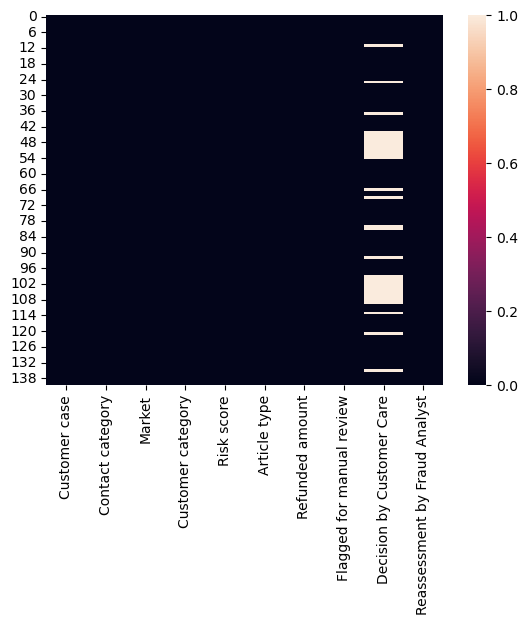

In [6]:
#can see a few nulls aroud, want to see if there's a pattern or what's going on
#I personally find it a little easier to visualise it this way to understand what is missing and where.
sns.heatmap(df.isnull())

Based on this it seems that there's only nnulls on a customer care decision - maybe domain knowledge would explain that, but not sure why it would be the case. Are some cases bypassed by CC and headed straight to fraud analysts?

In [7]:
df.describe()

,Customer case,Risk score,Refunded amount,Flagged for manual review
count,141.000000,141.000000,141.000000,141.000000
mean,71.000000,0.604935,210.956170,0.787234
std,40.847277,0.321005,842.958204,0.410723
min,1.000000,0.001000,9.000000,0.000000
25%,36.000000,0.291300,48.000000,1.000000
50%,71.000000,0.622000,87.000000,1.000000
75%,106.000000,0.980150,164.000000,1.000000
max,141.000000,0.996480,10001.700000,1.000000


To note from this overview: 
1. Avg refunded amount is 210 - that seems too high after quickly eyeballing the median.
2. Max is 10k refund that was considered fraud which is probably completely messing with everything - suss that row and see should we remove to get better info or if we should keep it in. 

In [8]:
df.corr()

,Customer case,Risk score,Refunded amount,Flagged for manual review
Customer case,1.000000,-0.510279,-0.088882,-0.063863
Risk score,-0.510279,1.000000,0.106634,0.261114
Refunded amount,-0.088882,0.106634,1.000000,0.028274
Flagged for manual review,-0.063863,0.261114,0.028274,1.000000


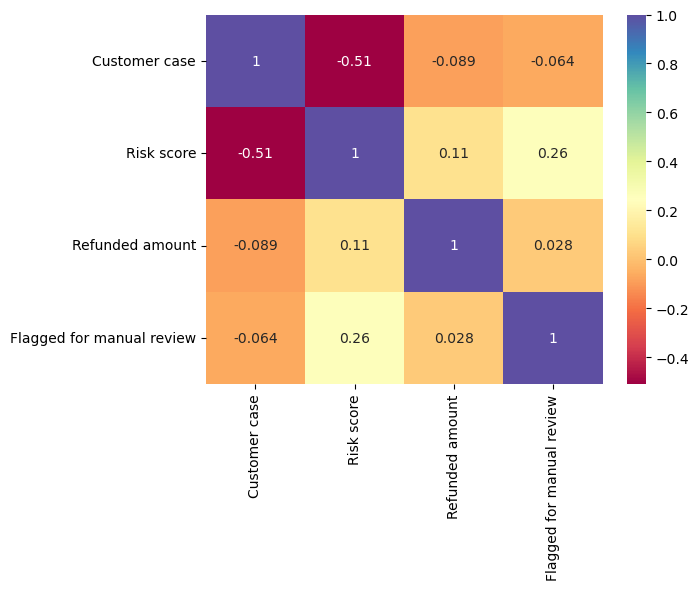

In [9]:
corr = df.corr()
sns.heatmap(corr, annot = True, cmap="Spectral")
plt.show()

Did a quick correlation here to see if certain things correlated more with fraud or not, but the data needs a lot of manipulation before this would be useful - would have to get dummies on stuff like market, product etc, so will leave this for now. Just wanted to have a look to see if anything was immediately apparent. 

# New columns

In [10]:
#saving as a variable for calculations
total_cases = df['Customer case'].count()

Need some new columns in binary so I can plot a little better - want 3 things out of this: 
1. ✅ Binary for when CC determined something fraud
2. ✅ Binary for when FA determined something fraud
3. ✅ Binary for when they agreed and when they didn't. 

In [11]:
df['cc_determined_fraud'] = np.where(df['Decision by Customer Care']=='FRAUD', 'yes', 'no')
df['fa_determined_fraud'] = np.where(df['Reassessment by Fraud Analyst']=='FRAUD', 'yes', 'no')

In [12]:
df['fa_fraud_binary'] = df['fa_determined_fraud'].map(dict(yes=1, no=0))
df['cc_fraud_binary'] = df['cc_determined_fraud'].map(dict(yes=1, no=0))

I'm 100% sure there's a more elegant way to do this, but this worked so will accept it for now.

I mapped it to yes no before binary, just so I could quality control and be sure it was all correct. It's a little clunky and unnecessary though so maybe I will now drop those yes no columns later. 

In [13]:
#one more to see if they agreed or not based on my new columns with good old np where
df['agreed'] = np.where(df['fa_fraud_binary']==df['cc_fraud_binary'], 1, 0)

In [14]:
df.head(5)

,Customer case,Contact category,Market,Customer category,Risk score,Article type,Refunded amount,Flagged for manual review,Decision by Customer Care,Reassessment by Fraud Analyst,cc_determined_fraud,fa_determined_fraud,fa_fraud_binary,cc_fraud_binary,agreed
0,1,Return,Germany,A (Premium),0.97820,Sneakers,75.95,1,FRAUD,FRAUD,yes,yes,1,1,1
1,2,Return,Germany,A (Premium),0.32877,Jeans,227.05,1,NOT FRAUD,NOT FRAUD,no,no,0,0,1
2,3,Return,Germany,C,0.97888,Sneakers,199.95,1,FRAUD,FRAUD,yes,yes,1,1,1
3,4,Delivery,France,B,0.97890,Sneakers,119.95,1,NOT FRAUD,NOT FRAUD,no,no,0,0,1
4,5,Delivery,Germany,C,0.97892,Jeans,33.95,1,FRAUD,FRAUD,yes,yes,1,1,1


Ok now cross checked this sample and looks correct so can drop the columns I don't need. 

In [15]:
df = df.drop(['cc_determined_fraud'], axis = 1)
df = df.drop(['fa_determined_fraud'], axis = 1)
df.head(5)

,Customer case,Contact category,Market,Customer category,Risk score,Article type,Refunded amount,Flagged for manual review,Decision by Customer Care,Reassessment by Fraud Analyst,fa_fraud_binary,cc_fraud_binary,agreed
0,1,Return,Germany,A (Premium),0.97820,Sneakers,75.95,1,FRAUD,FRAUD,1,1,1
1,2,Return,Germany,A (Premium),0.32877,Jeans,227.05,1,NOT FRAUD,NOT FRAUD,0,0,1
2,3,Return,Germany,C,0.97888,Sneakers,199.95,1,FRAUD,FRAUD,1,1,1
3,4,Delivery,France,B,0.97890,Sneakers,119.95,1,NOT FRAUD,NOT FRAUD,0,0,1
4,5,Delivery,Germany,C,0.97892,Jeans,33.95,1,FRAUD,FRAUD,1,1,1


In [16]:
df['agreed'].sum()

99

Ok great, now I have some new columns where I can do some correlations and calculations. 
This is slightly clunky and I could probably have done get dummies, but wanted to go through and keep an eye on it all being correct and get to know the data a little more. 

In [17]:
#Insights based on the above:

fraud_count = df['fa_fraud_binary'].sum()
print(f'The total fraud count of the dataset is {fraud_count}')
fraud_rate = (fraud_count/total_cases)
print(f'The total fraud rate of the dataset is {fraud_rate}')
fraud_rate_percent = ((fraud_count/total_cases) * 100).round(1)
print(f'The total fraud rate percent is {fraud_rate_percent}%')
print('---')

agreed_count = df['agreed'].sum()
print(f'The number of cases where customer case and fraud analysts agreed was {agreed_count}')
agreement_rate = agreed_count/total_cases
print(f'The total agreement rate of the dataset is {agreement_rate}')
agreement_percent = (agreement_rate * 100).round(1)
print(f'The agreement percent is {agreement_percent}%')
print('---')

flagged_count = df['Flagged for manual review'].sum()
print(f'The flagged for manual review count is {flagged_count}')
flagged_rate = (flagged_count/total_cases)
print(f'The total flag rate is {flagged_rate}')
flagged_percent = (flagged_rate * 100).round(1)
print(f'The flagged percent is {flagged_percent}%')
print('---')


The total fraud count of the dataset is 92
The total fraud rate of the dataset is 0.6524822695035462
The total fraud rate percent is 65.2%
---
The number of cases where customer case and fraud analysts agreed was 99
The total agreement rate of the dataset is 0.7021276595744681
The agreement percent is 70.2%
---
The flagged for manual review count is 111
The total flag rate is 0.7872340425531915
The flagged percent is 78.7%
---


#### Initial Takeaways 

This dataset doesn't seem representative of a real fraud one, as it's not as skewed as I would expect - obviously a real dataset would be significantly less fraud. 
I am surprised at only a 70% agreement rate between customer care and fraud analysts - would have expected this to be slightly higher. 

# Initial points of interest - Market/Customer

Will do a few quick overview graphs that don't necessarily answer the question, but give me a better overview of where we are lacking and where are the problematic areas. 

Hypotheses: 
Fraud will be higher on items that are easier to resell - eg sizeless items like watches
The majority of the disagreements between customer care and fraud analysts will be in the mid range of the risk score. Should plot them

What are the relationships between specific things like fraud and market, fraud and premium, fraud and article type etc. 

In [18]:
groupby_market = df.groupby(['Market'])
# normalise = True so we get percentages so it's easier to see if anything looks totally wrong
market_fraud_rates = groupby_market['fa_fraud_binary'].value_counts(normalize = True)
market_fraud_rates

Market   fa_fraud_binary
France   1                  0.705882
         0                  0.294118
Germany  1                  0.656250
         0                  0.343750
Sweden   1                  0.538462
         0                  0.461538
Name: fa_fraud_binary, dtype: float64

In this dataset the fraud percentage is showing that proportionally France is more problematic for fraud as in this dataset 70% of France cases are fraud. Sweden is the least. 

Text(0, 0.5, 'Fraud count')

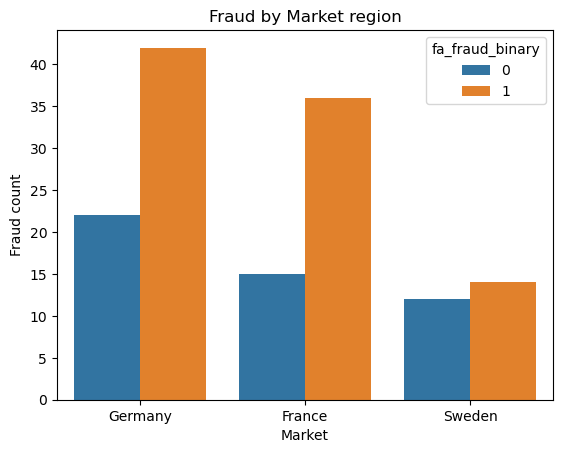

In [19]:
sns.countplot(data=df, x='Market', hue='fa_fraud_binary')

# Set plot title and labels
plt.title('Fraud by Market region')
plt.xlabel('Market')
plt.ylabel('Fraud count')

<AxesSubplot:xlabel='fa_fraud_binary'>

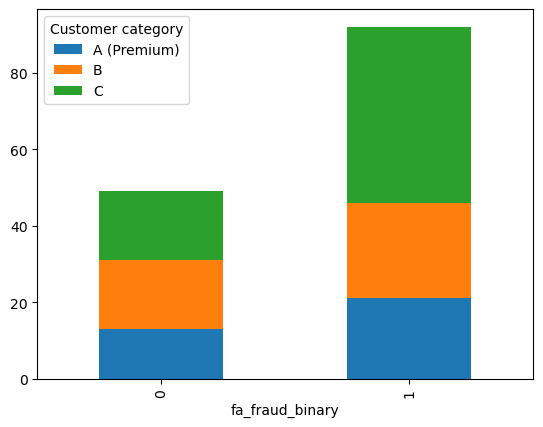

In [20]:
df_cstcat = df.groupby(['Customer category', 'fa_fraud_binary']).size().reset_index().pivot(columns='Customer category', index='fa_fraud_binary', values=0)
df_cstcat.plot(kind='bar', stacked=True)


Takeaway: 
Sweden seems pleasantly unproblematic in this dataset :) 
Seems that the Fraud of cat A is lower, C is higher. Fits my hypothesis as wouldn't really have expected fraudsters to pay premium to pull off better fraud. 

This shows us that the most common category for fraud in Germany and France is category C, but that's the opposite case in Sweden, where it's category B. Not sure what this means in terms of domain knowledge (is category B more like A or more like c? Do they pay extra for membership or what's the story?)
Anyway, interesting to note quite a large difference in markets there, which is worth paying attention to. 

Text(0, 0.5, 'Fraud count')

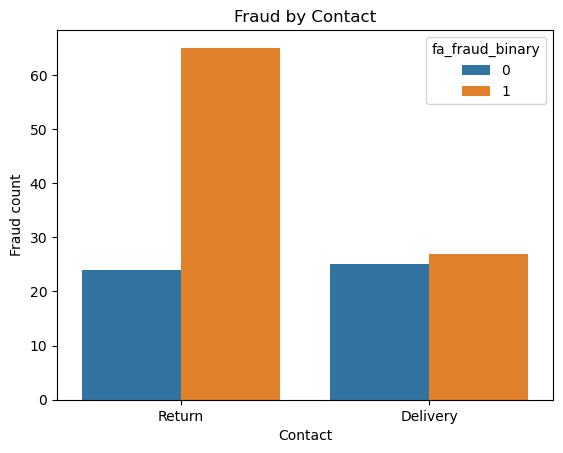

In [21]:
sns.countplot(data=df, x='Contact category', hue='fa_fraud_binary')

# Set plot title and labels
plt.title('Fraud by Contact')
plt.xlabel('Contact')
plt.ylabel('Fraud count')

<AxesSubplot:xlabel='fa_fraud_binary'>

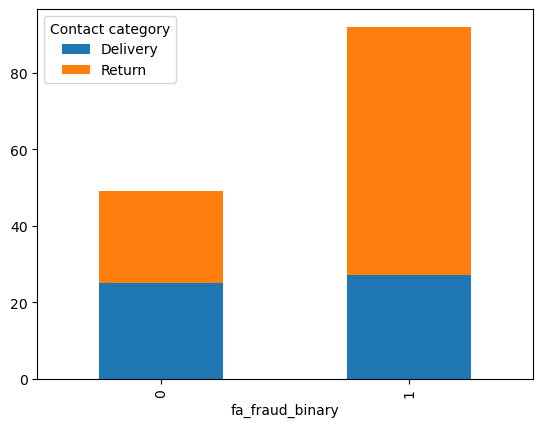

In [22]:
df_cstcat = df.groupby(['Contact category', 'fa_fraud_binary']).size().reset_index().pivot(columns='Contact category', index='fa_fraud_binary', values=0)
df_cstcat.plot(kind='bar', stacked=True)


Seems that there's significantly more fraud when people are contacting regarding a return rather than just a delivery. Not sure what to make of this, probably some domain knowledge here would be useful! As it's 'returns fraud' I guess it makes sense, but still good to confirm it and see it mapped out there. 

# Initial points of interest - Amount

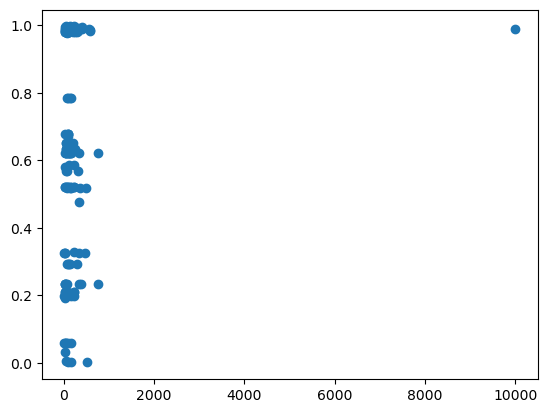

In [23]:
plt.scatter(df['Refunded amount'],df['Risk score'])

Ok can't see the data because of that outlier. The outlier shouldn't be deleted really without verifying that it's incorrect, which I can't. 
(If it was a real order then it should stay in there, as it's still very relevant and high value fraud if it's the case.) 
However for the sake of viewing the rest I will remove it.
I would also remove it from the ML algo because it's such an outlier it'll skew everything and affect the accuracy. 

In [24]:
#honestly - here I Just used ctrl f to find the one i wanted for 10k in the data sheet
df.iloc[36] # making sure it was the correct row

Customer case                          37
Contact category                 Delivery
Market                            Germany
Customer category                       C
Risk score                        0.98995
Article type                     Sneakers
Refunded amount                   10001.7
Flagged for manual review               1
Decision by Customer Care           FRAUD
Reassessment by Fraud Analyst       FRAUD
fa_fraud_binary                         1
cc_fraud_binary                         1
agreed                                  1
Name: 36, dtype: object

In [25]:
#want to drop customer case 37 (which is row 36 in Python)
df_for_viz = df.drop([36])

## Impact of dropping outliers on clarity of data

Text(0.5, 1.0, 'Refunded amount v risk score')

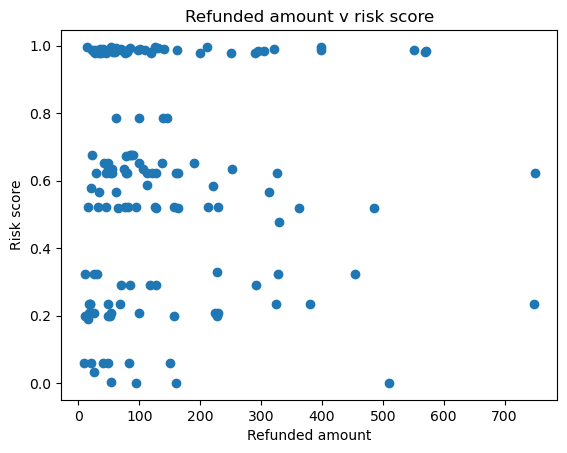

In [26]:
plt.scatter(df_for_viz['Refunded amount'],df_for_viz['Risk score'])
plt.xlabel('Refunded amount')
plt.ylabel('Risk score')
plt.title('Refunded amount v risk score')

Ok that's better, can see a bit more now the outlier is gone. 

Not sure what to make of this though tbh. I'm quite surprised at it. 

It seems like there are lots of points in the high risk low value section (which I wouldn't necessarily have expected to be the most concentrated block). 

However, that scatter only shows risk score vs transaction amount, would now be interesting to see that but with them marked as fraud or not. 

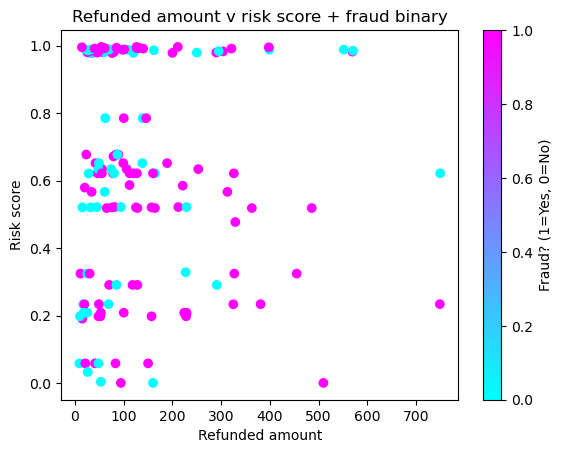

In [27]:
plt.scatter(df_for_viz['Refunded amount'],df_for_viz['Risk score'], c=df_for_viz['fa_fraud_binary'], cmap='cool')
plt.xlabel('Refunded amount')
plt.ylabel('Risk score')
plt.title('Refunded amount v risk score + fraud binary')
plt.colorbar(label='Fraud? (1=Yes, 0=No)')

Histo correlation between amount and fraud like step 4 here: https://github.com/Aoifeni/ReDI/blob/main/Titanic_Explore_Updated.ipynb



<AxesSubplot:>

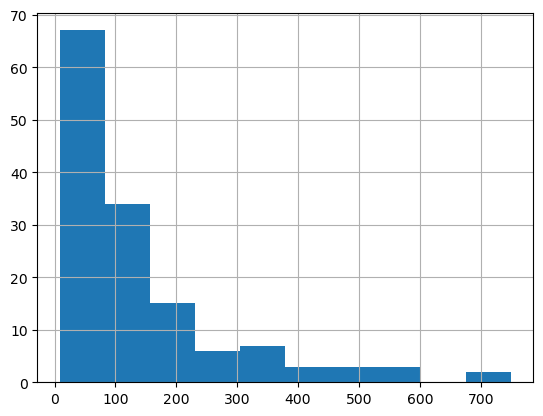

In [28]:
# Distribution of the prices of the transactions - all including fraud and non fraud
df_for_viz['Refunded amount'].hist(bins = 10)

In [29]:
df_for_viz_fraud = df_for_viz[df_for_viz['fa_fraud_binary'] == 1]

<AxesSubplot:>

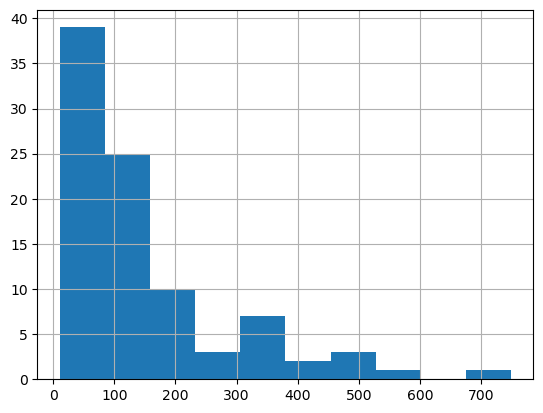

In [30]:
# Distribution of the prices of the fraudulent transactions to compare
df_for_viz_fraud['Refunded amount'].hist(bins = 10)

The distribution regarding amount (when that one outlier is excluded is actually pretty similar to the non fraudulent one apart from a small bump at the 300 and 500€ mark).

In [31]:
#Just out of interest- what is the highest and lowest transaction amount that was considered fraud? 
#And the highest and lowest that wasn't fraud

transaction_fraud = df[df['fa_fraud_binary'] == 1]
highest_tx = transaction_fraud['Refunded amount'].max()
print(f'The highest fraud transaction is {highest_tx}')
lowest_tx = transaction_fraud['Refunded amount'].min()
print(f'The lowest fraud transaction is {lowest_tx}')

non_fraud = df[df['fa_fraud_binary'] == 0]
highest_tx_nf = non_fraud['Refunded amount'].max()
print(f'The highest fraud transaction is {highest_tx_nf}')
lowest_tx_nf = non_fraud['Refunded amount'].min()
print(f'The lowest fraud transaction is {lowest_tx_nf}')

The highest fraud transaction is 10001.7
The lowest fraud transaction is 11.0
The highest fraud transaction is 749.65
The lowest fraud transaction is 9.0


risk score by cc, and fa, out of interest. 

# Initial points of interest: Risk Score + Decisions

How many with a risk score above 0.9 was flagged, and how many were considered not fraud? 
Is there time wasting there? 
What's our false pos rate? 

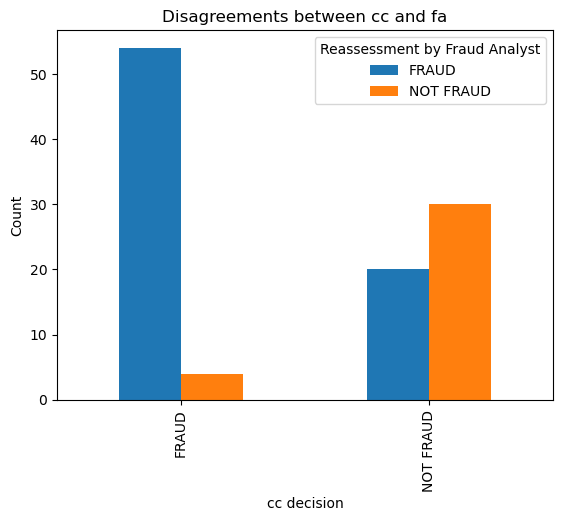

In [32]:
grouped_decision = df.groupby(['Decision by Customer Care', 'Reassessment by Fraud Analyst']).size().unstack(fill_value=0)
grouped_decision.plot(kind='bar')
plt.xlabel('cc decision')
plt.ylabel('Count')
plt.title('Disagreements between cc and fa')
plt.legend(title='Reassessment by Fraud Analyst')
plt.show()
#learnt something new here - this was my first time using unstack: https://www.geeksforgeeks.org/pandas-groupby-unstack/

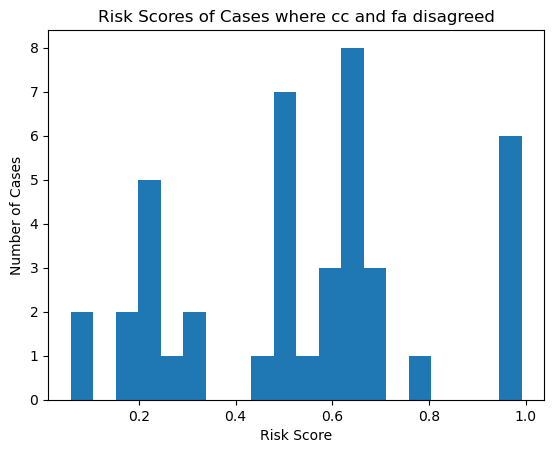

In [33]:
#One try first
cases_with_disagreement = df[df['agreed'] == 0]

plt.hist(cases_with_disagreement['Risk score'], bins=20)
plt.xlabel('Risk Score')
plt.ylabel('Number of Cases')
plt.title('Risk Scores of Cases where cc and fa disagreed')
plt.show()

So there are a few types of falses we need to look at. 
Based on the top graph, it seems that generally when customer care thinks something is fraud, they are correct, with only a few cases being marked not fraud by fraud analysts afterwards.) This is a small amount of false positive fraud. 

Then there is a false negative - it seems from the above graph that there are more cases of these, which cause losses to the company. This false negative is when the cc team doesn't think it's fraud, but reassessment says that is is. 

However it seems that there's no clear weak area in terms of risk score- for example its' not like there's main disagreements in the low risk section - it is quite in the middle, so there's no specific weak area to try working on. 

Let's also check the ML false positives - those where they were flagged for review, and ended up not being fraud. 

# ML performance

In [34]:
ml_was_right = df[(df['Flagged for manual review'] == 1) & (df['fa_fraud_binary'] == 1)]
ml_was_right_percentage = len(ml_was_right) / total_cases * 100
print(f"ML was right percentage: {ml_was_right_percentage:}%")
print(len(ml_was_right))

ML was right percentage: 53.90070921985816%
76


In [35]:
ml_false_positives = df[(df['Flagged for manual review'] == 1) & (df['fa_fraud_binary'] == 0)]
#we already know flagged count from before
false_positive_percentage = len(ml_false_positives) / flagged_count * 100
print(f"Percentage of False Positives: {false_positive_percentage:}%")

Percentage of False Positives: 31.53153153153153%


In [36]:
ml_false_negatives = df[(df['Flagged for manual review'] == 0) & (df['fa_fraud_binary'] == 1)]
#we already know flagged count from before
false_negative_percentage = len(ml_false_negatives) / flagged_count * 100
print(f"Percentage of False Negatives: {false_negative_percentage:}%")

Percentage of False Negatives: 14.414414414414415%


In [37]:
ml_false_negatives['Refunded amount'].sum()

3272.63

In [38]:
ml_false_positives['Refunded amount'].sum()

4398.39

Ok so at the moment if we classify false positive as being flagged for a manual review and it ends up not being fraud, we get an actually really high rate - 31%.

<AxesSubplot:xlabel='Flagged for manual review', ylabel='count'>

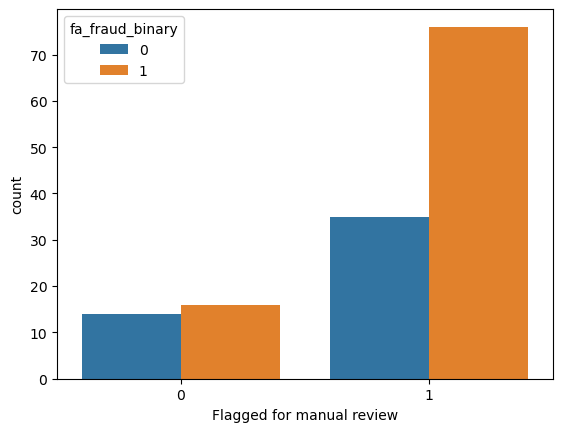

In [39]:
#visualising it as it's a little easier to make sense of
sns.countplot(data=df, x='Flagged for manual review', hue='fa_fraud_binary')

Another thing to work out:
How many tx with risk score of over 0.9 are manually reviewed and determined to be fraud? Can we eliminate the need to review these? 

In [40]:
#defining high risk and ultra high risk
high_risk = df[(df['Risk score'] >0.90)]
ultra_high_risk = df[(df['Risk score'] >0.98)]
count_high_risk =  (len(high_risk))
count_ultra_high_risk =  (len(ultra_high_risk))

In [41]:
print(f'The high risk count is {count_high_risk}')
high_risk_rate = (count_high_risk/total_cases)
print(f'The total high risk rate is {high_risk_rate}')
high_risk_percent = (high_risk_rate * 100).round(1)
print(f'The high risk percent is {high_risk_percent}% of all transactions')
print('---')
print(f'The ultra high risk count is {count_ultra_high_risk}')
ultra_high_risk_rate = (count_ultra_high_risk/total_cases)
print(f'The total high risk fraud rate is {ultra_high_risk_rate}')
ultra_high_risk_percent = (ultra_high_risk_rate * 100).round(1)
print(f'The ultra_high risk percent is {ultra_high_risk_percent}% of all transactions')
print('---')

The high risk count is 45
The total high risk rate is 0.3191489361702128
The high risk percent is 31.9% of all transactions
---
The ultra high risk count is 36
The total high risk fraud rate is 0.2553191489361702
The ultra_high risk percent is 25.5% of all transactions
---


In [42]:
#Of those that are high risk, what percent are fraud? 
percentage_fraud_high_risk = (high_risk['fa_fraud_binary'] == 1).mean() * 100
print(f'Of the high risk transfers, the percentage of those that are fraud are {percentage_fraud_high_risk}%')

percentage_fraud_ultra_high_risk = (ultra_high_risk['fa_fraud_binary'] == 1).mean() * 100
print(f'Of the high risk transfers, the percentage of those that are fraud are {percentage_fraud_ultra_high_risk}%')

Of the high risk transfers, the percentage of those that are fraud are 64.44444444444444%
Of the high risk transfers, the percentage of those that are fraud are 66.66666666666666%


In [43]:
#defining low risk and ultra low risk
low_risk = df[(df['Risk score'] < 0.30)]
ultra_low_risk = df[(df['Risk score'] < 0.10)]
count_low_risk =  (len(low_risk))
count_ultra_low_risk =  (len(ultra_low_risk))

In [44]:
#same for low risk, maybe there's something to see there. 

print(f'The low risk count is {count_low_risk}')
low_risk_rate = (count_low_risk/total_cases)
print(f'The total low risk rate is {low_risk_rate}')
low_risk_percent = (low_risk_rate * 100).round(1)
print(f'The low risk percent is {low_risk_percent}% of all transactions')
print('---')
print(f'The ultra low risk count is {count_ultra_low_risk}')
ultra_low_risk_rate = (count_ultra_low_risk/total_cases)
print(f'The total low risk fraud rate is {ultra_low_risk_rate}')
ultra_low_risk_percent = (ultra_low_risk_rate * 100).round(1)
print(f'The ultra_low risk percent is {ultra_low_risk_percent}% of all transactions')
print('---')

The low risk count is 36
The total low risk rate is 0.2553191489361702
The low risk percent is 25.5% of all transactions
---
The ultra low risk count is 11
The total low risk fraud rate is 0.07801418439716312
The ultra_low risk percent is 7.8% of all transactions
---


In [45]:
#Of those that are high risk, what percent are fraud? 
percentage_fraud_low_risk = (low_risk['fa_fraud_binary'] == 1).mean() * 100
print(f'Of the low risk transfers, the percentage of those that are fraud are {percentage_fraud_low_risk}%')

percentage_fraud_ultra_low_risk = (ultra_low_risk['fa_fraud_binary'] == 1).mean() * 100
print(f'Of the low risk transfers, the percentage of those that are fraud are {percentage_fraud_ultra_low_risk}%')

Of the low risk transfers, the percentage of those that are fraud are 63.888888888888886%
Of the low risk transfers, the percentage of those that are fraud are 54.54545454545454%


One last thing: Can we get the data in a decent format to make a sankey graph?



## Baseline accuracy

In [46]:
#taken from when I did baseline accuracy calc for titanic dataset - the old classic
# we already know that the 
overall_fraud_rate = 0.65
#so the
overall_non_fraud_rate = 0.35
#Odds of Guessing fraud correctly: 
fraud_guess_chance = overall_fraud_rate * overall_fraud_rate
print(f'The chance of guessing fraud rate correctly is {fraud_guess_chance}')
#Odds of Guessing non_Fraud correctly: 
non_fraud_guess_chance = overall_non_fraud_rate * overall_non_fraud_rate
print(f'The chance of guessing non fraud rate correctly is {non_fraud_guess_chance}')
baseline = overall_fraud_rate**2 + overall_non_fraud_rate**2 
print(f'The baseline is {baseline}')

The chance of guessing fraud rate correctly is 0.42250000000000004
The chance of guessing non fraud rate correctly is 0.12249999999999998
The baseline is 0.545


Zero rate classifier: 
If you were just to guess everything was the most frequently occuring option (in this case, fraud) you would be correct 65% of the time, so any machine learning model have to significantly outperform this to be worth while! 

## Extra

This is not relevant, but just doing it again now there's more encoded columns seeing if there's something more interesting to see

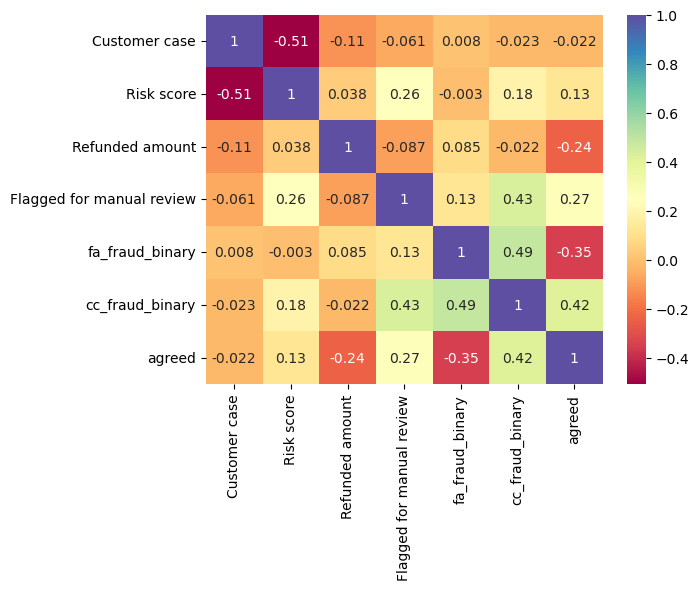

In [47]:
corr = df_for_viz.corr()
sns.heatmap(corr, annot = True, cmap="Spectral")
plt.show()

Running this when there's more numerical columns is cool - here we have proof that there's high correlation between manual review flagging, and the CC decision, and with the CC decision to the FA decision. So you can see it getting closer to the correct determination as you go.
It also confirms to use that amount is seemingly doesn't' have much correlation with if something is fraud or not, which is not necessarily what I was expecting when I started the task. 

Would have liked to make a sankey out of this, but ran out of time! 

In [48]:
sankeydata = pd.DataFrame({
    'ML FLAGGED': ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "Yes"],
    'CC decision': ["Fraud", "Not Fraud", "Not Fraud", "No assessment", "Fraud", "No assessment", "No assessment", "No assessment"],
    'FA decision': ["Fraud", "Not Fraud", "Fraud", "Not Fraud", "Not Fraud", "Fraud", "Fraud", "Not Fraud"],
    'Value': [54, 30, 20, 14, 4, 16, 2, 1]
})
values = sankeydata['Value'].values